In [294]:
import json
import wandb
import pandas as pd

def get_tables(run_id):
    with wandb.init() as run:
        dfs = {}
        for bench in ['medqa', 'mmlumed', 'medmcqa']:
            artifact = run.use_artifact(f'liac/OntoRAG-biomed/run-{run_id}-results_{bench}:v0', type='run_table')
            artifact_dir = artifact.download()
            dfjson = json.load(open(artifact_dir + f'/results_{bench}.table.json'))
            df = pd.DataFrame(dfjson['data'], columns=dfjson['columns'])
            dfs[bench] = df
    return dfs

def reorganize_dataframe(df, k):
    """There was an error when uploading the table, fixed now."""
    if 'reasoning' in df.columns:
        df = df.drop(columns=['reasoning'])

    new_rows = []
    ncols = df.shape[1]
    k=2
    for i in range(0, len(df), 2):
        if i+1 < len(df):
            new_row = list(df.iloc[i].values[:ncols-k]) + list(df.iloc[i+1].values[-k:])
            new_rows.append(new_row)
    return pd.DataFrame(new_rows, columns=df.columns)

runs = {
    'b7uddust': 'ontorag_simple',
    '1bfubxbi': 'ontorag_hypoans',
    'fet7zafh': 'rag_zeroshot',
    'koy4ku55': 'rag_reason',
    'w63choo1': 'ontorag_tm',
    'uwui3p75': 'ontorag_tmhypoans',
}

for run, name in runs.items():
    dfm = get_tables(run)
    for k, df in dfm.items():
        if 'tm' not in name:
            df = reorganize_dataframe(df, 2)
        df.to_csv(f'data/_{k}_{name}.csv', index=False, sep='\t')

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [275]:
# Load the dataframes
dfm_orag = {}
dfm_zs = {}
for bench in ['medqa', 'mmlumed', 'medmcqa']:
    dfm_orag[bench] = pd.read_csv(f'data/{bench}_ontorag.csv', sep='\t')
    dfm_zs[bench] = pd.read_csv(f'data/{bench}_baseline.csv', sep='\t')

import numpy as np

# Print accuracy for eahc benchmark
for bench in ['medqa', 'mmlumed', 'medmcqa']:
    print(f'{bench}: {np.mean(dfm_orag[bench]["answer"] == dfm_orag[bench]["choice_answer"])*100:.4f}')
    print(f'{bench}: {np.mean(dfm_zs[bench]["answer"] == dfm_zs[bench]["choice_answer"])*100:.4f}')
    print('---')

medqa: 70.3064
medqa: 68.0283
---
mmlumed: 81.8279
mmlumed: 82.2020
---
medmcqa: 62.7062
medmcqa: 64.8099
---


In [282]:
# Lets see per class

results_compare = {}
for bench in ['medqa', 'mmlumed', 'medmcqa']:
    compare = []
    for name, dfm in zip(['OntoRAG', 'ZeroShot'], [dfm_orag, dfm_zs]):
        if 'class_1' not in dfm[bench]:
            dfm[bench]['class_1'] = dfm[bench]['class']
        compare.append(
            dfm[bench].groupby('class_1').apply(
                lambda x: pd.Series(
                    {
                        name: np.mean(x['answer'] == x['choice_answer'])*100,
                        f'{name}_context_len': np.mean(x['context'].astype(str).apply(len)),
                        'len': len(x['context']),
                    },
                ), include_groups=False
            )
        )

    compare = pd.concat(compare, axis=1).T.drop_duplicates().T
    comp_sorted = compare.sort_values('len', ascending=False)
    results_compare[bench] = comp_sorted
    display(comp_sorted.loc[comp_sorted['len'] > 10].head())
    print('---')

OntoRAG  OntoRAG_context_len    len   ZeroShot  \
class_1                                                                      
Medicine                  68.461538          2503.138462  260.0  63.846154   
Pediatrics                72.131148          2191.562842  183.0  69.945355   
Gynaecology & Obstetrics  71.111111          2119.505556  180.0  70.000000   
Psychiatry                72.815534          2240.679612  103.0  69.902913   
Pharmacology              72.727273          2027.727273   88.0  77.272727   

                          ZeroShot_context_len  
class_1                                         
Medicine                                   3.0  
Pediatrics                                 3.0  
Gynaecology & Obstetrics                   3.0  
Psychiatry                                 3.0  
Pharmacology                               3.0

---


OntoRAG  OntoRAG_context_len    len  \
class_1                                                               
Unknown                       83.703704          1046.859259  405.0   
Biochemistry                  84.887460          1414.411576  311.0   
Physiology                    83.392226          1309.077739  283.0   
Medicine                      86.153846          1604.123077  130.0   
Social & Preventive Medicine  69.565217          1016.119565   92.0   

                               ZeroShot  ZeroShot_context_len  
class_1                                                        
Unknown                       84.444444                   3.0  
Biochemistry                  84.887460                   3.0  
Physiology                    83.392226                   3.0  
Medicine                      90.769231                   3.0  
Social & Preventive Medicine  78.260870                   3.0

---


OntoRAG  OntoRAG_context_len     len   ZeroShot  \
class_1                                                           
Dental        48.254932           885.283763  1318.0  55.083460   
Surgery       60.975610          1361.598916   369.0  62.059621   
Pathology     77.151335          1324.192878   337.0  75.370920   
Medicine      65.423729          1461.616949   295.0  68.135593   
Pharmacology  80.246914          1106.481481   243.0  81.893004   

              ZeroShot_context_len  
class_1                             
Dental                         3.0  
Surgery                        3.0  
Pathology                      3.0  
Medicine                       3.0  
Pharmacology                   3.0

---


In [283]:
# Correlation between context length and correct answer
for k, df in dfm_orag.items():
    df['context_len'] = df['context'].apply(len)
    df['correct_answer'] = df['answer'] == df['choice_answer']
    display(df[['correct_answer', 'context_len']].corr())

for k, df in dfm_zs.items():
    df['context_len'] = None

correct_answer  context_len
correct_answer         1.00000     -0.03677
context_len           -0.03677      1.00000

correct_answer  context_len
correct_answer        1.000000    -0.003675
context_len          -0.003675     1.000000

correct_answer  context_len
correct_answer        1.000000     0.080615
context_len           0.080615     1.000000

In [284]:
# Get an order based on the number of examples for each class, for classes where all benchmarks have more than 10 examples

order = []
for bench in ['medqa', 'mmlumed', 'medmcqa']:
    order.append(results_compare[bench]['len'])

order = pd.concat(order, axis=1)
order = order[order.apply(lambda x: all(x>10), axis=1)].sum(axis=1).sort_values(ascending=False).index
order

Index(['Medicine', 'Physiology', 'Pediatrics', 'Gynaecology & Obstetrics',
       'Surgery', 'Pharmacology', 'Pathology', 'Microbiology',
       'Social & Preventive Medicine', 'Psychiatry', 'Ophthalmology',
       'Orthopaedics'],
      dtype='object', name='class_1')

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.ioff()
fig, ax = plt.subplots(3, 2, figsize=(18, 18), gridspec_kw={'hspace': 0.8})

for i, bench in enumerate(['medqa', 'mmlumed', 'medmcqa']):
    data = results_compare[bench].reset_index().melt(value_vars=['OntoRAG', 'ZeroShot'], id_vars=['class_1', 'len', 'OntoRAG_context_len'], var_name='variable', value_name='accuracy')
    data = data.set_index('class_1').loc[order]

    sns.barplot(
        data = data,
        x = 'class_1',
        y = 'accuracy',
        hue = 'variable',
        ax = ax[i, 0],
    )

    # overlay context_len as a new y axis lineplot
    ax2 = ax[i,0].twinx()
    sns.lineplot(
        data = data,
        x = 'class_1',
        y = 'OntoRAG_context_len',
        ax = ax2,
        color = 'black',
        alpha = 1,
    )
    ax[i,0].set_title(bench)
    ax[i,0].set_xlabel('')
    ax[i,0].legend(loc='lower left')

    # rotate x labels
    for tick in ax[i,0].get_xticklabels():
        tick.set_rotation(90)

# plt.show()

In [286]:
# Investigate refusal
# Remove everything that is not directly an answer (in 'ABCDE')

dfref_orag = {}
dfref_zs = {}
for k, df in dfm_orag.items():
    valid_str = 'ABCDE' if k=='medqa' else 'ABCD'
    df_ = df.copy()
    df_['choice_answer'] = df_['choice_answer'].astype(str).apply(lambda x: x if x in valid_str else None)
    dfref_orag[k] = df_.dropna(subset=['choice_answer'])
    dfref_zs[k] = dfm_zs[k].iloc[dfref_orag[k].index]

# Describre results: how many samples were dropped
for k, df in dfref_orag.items():
    print(f'{k}: {len(dfm_orag[k]) - len(df)}')

medqa: 3
mmlumed: 26
medmcqa: 204


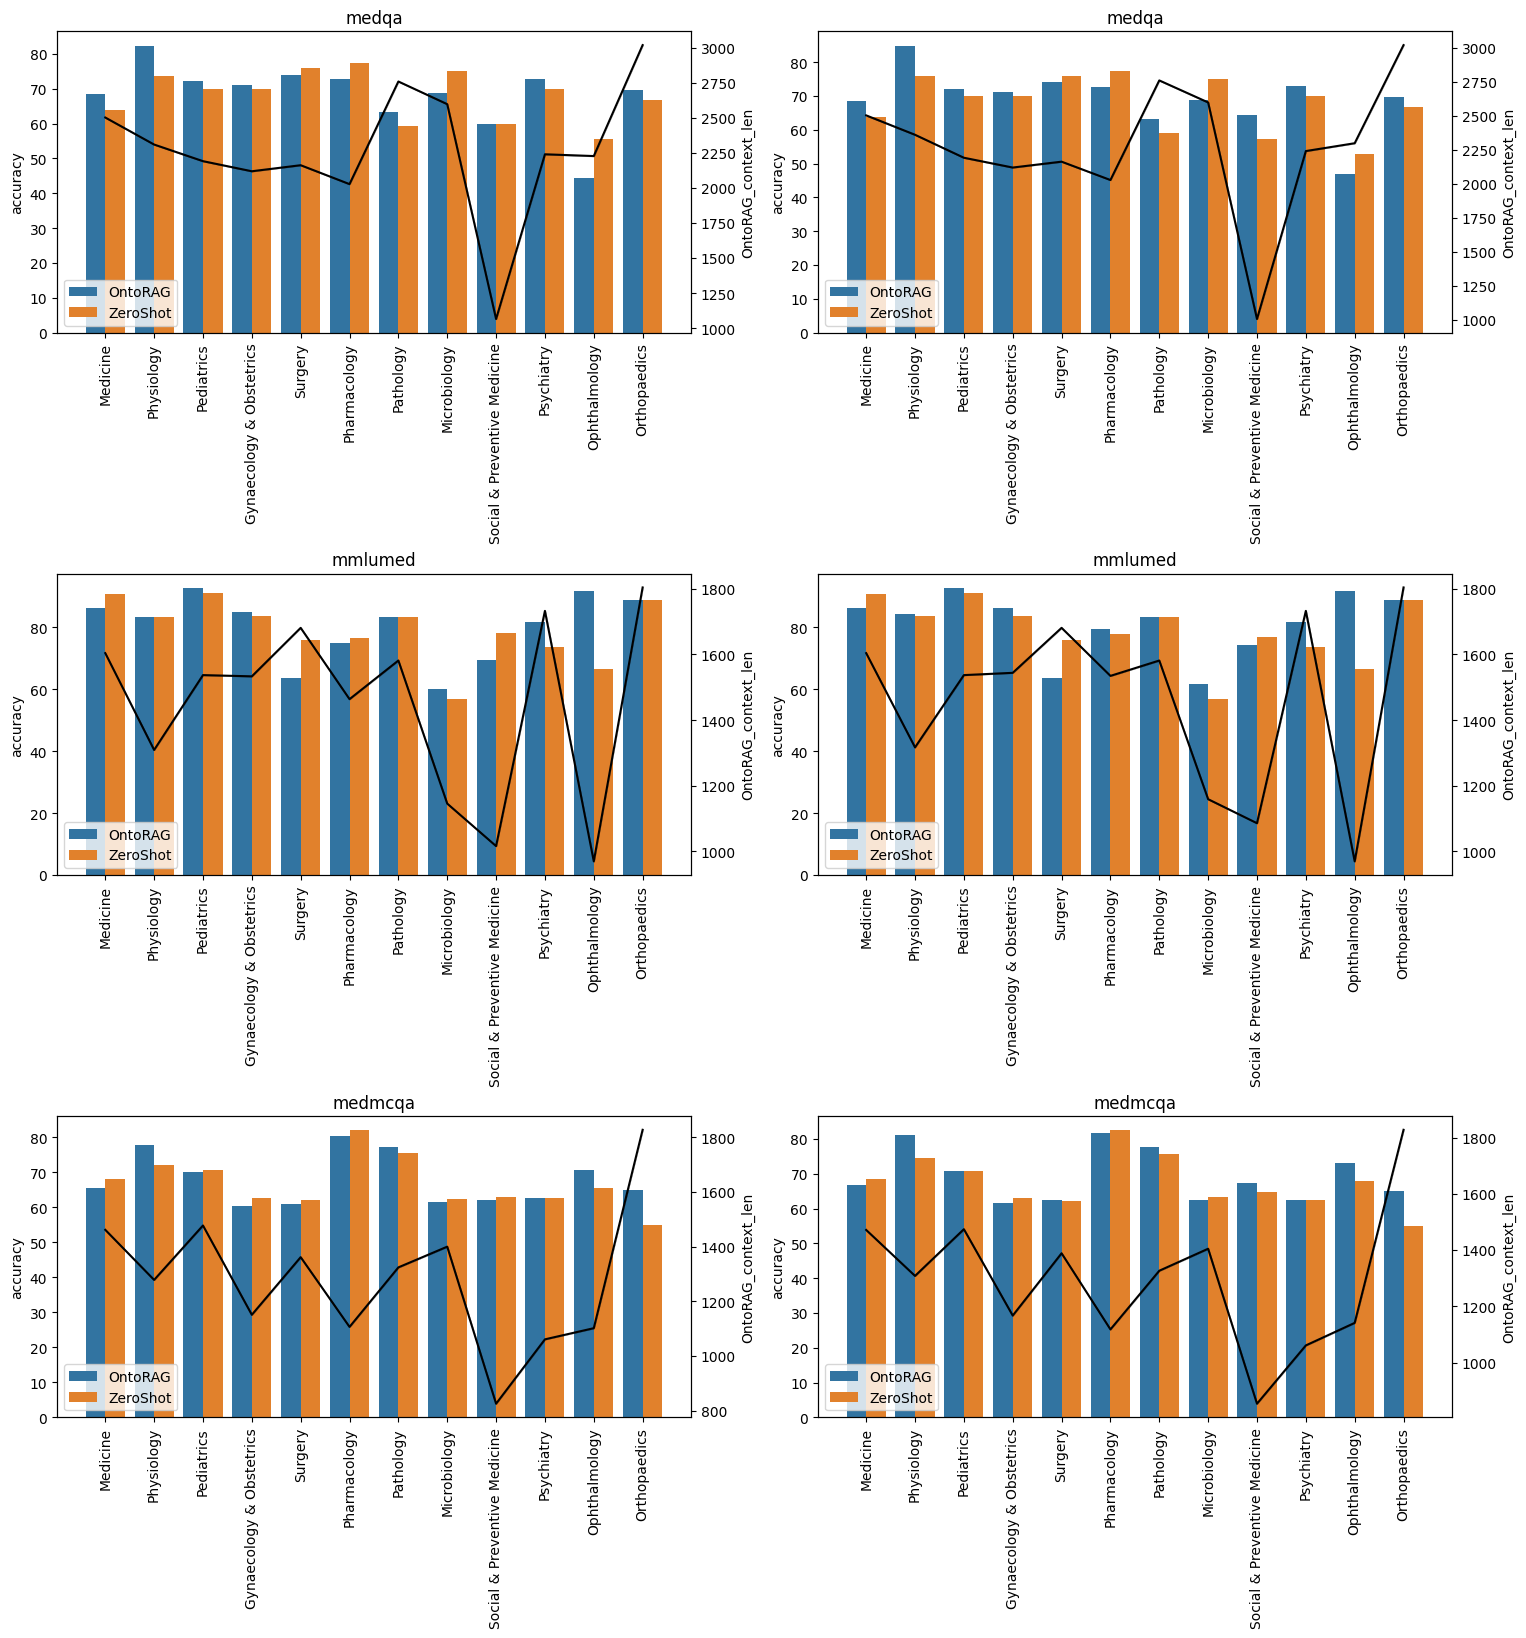

In [287]:
# Lets see per class

results_compare = {}
for bench in ['medqa', 'mmlumed', 'medmcqa']:
    compare = []
    for name, dfm in zip(['OntoRAG', 'ZeroShot'], [dfref_orag, dfref_zs]):
        if 'class_1' not in dfm[bench]:
            dfm[bench]['class_1'] = dfm[bench]['class']
        compare.append(
            dfm[bench].groupby('class_1').apply(
                lambda x: pd.Series(
                    {
                        name: np.mean(x['answer'] == x['choice_answer'])*100,
                        f'{name}_context_len': np.mean(x['context'].astype(str).apply(len)),
                        'len': len(x['context']),
                    },
                ), include_groups=False
            )
        )

    compare = pd.concat(compare, axis=1).T.drop_duplicates().T
    comp_sorted = compare.sort_values('len', ascending=False)
    results_compare[bench] = comp_sorted
    # display(comp_sorted.loc[comp_sorted['len'] > 10].head())
    # print('---')

# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(3, 1, figsize=(10, 18), gridspec_kw={'hspace': 0.8})

for i, bench in enumerate(['medqa', 'mmlumed', 'medmcqa']):
    data = results_compare[bench].reset_index().melt(value_vars=['OntoRAG', 'ZeroShot'], id_vars=['class_1', 'len', 'OntoRAG_context_len'], var_name='variable', value_name='accuracy')
    data = data.set_index('class_1').loc[order]

    sns.barplot(
        data = data,
        x = 'class_1',
        y = 'accuracy',
        hue = 'variable',
        ax = ax[i,1],
    )

    # overlay context_len as a new y axis lineplot
    ax2 = ax[i,1].twinx()
    sns.lineplot(
        data = data,
        x = 'class_1',
        y = 'OntoRAG_context_len',
        ax = ax2,
        color = 'black',
        alpha = 1,
    )
    ax[i,1].set_title(bench)
    ax[i,1].set_xlabel('')
    ax[i,1].legend(loc='lower left')

    # rotate x labels
    for tick in ax[i,1].get_xticklabels():
        tick.set_rotation(90)

plt.show()

In [293]:
# Recalculate accuracies for both refusal and normal
for k, df in dfref_orag.items():
    oragaft = np.mean(df["answer"] == df["choice_answer"])*100
    zsaft = np.mean(dfref_zs[k]["answer"] == dfref_zs[k]["choice_answer"])*100
    print(f'{k}: {oragaft:.4f}, {zsaft:.4f}')
    
    oragbef = np.mean(dfm_orag[k]["answer"] == dfm_orag[k]["choice_answer"])*100
    zsbef = np.mean(dfm_zs[k]["answer"] == dfm_zs[k]["choice_answer"])*100
    print(f'{k}: {oragbef:.4f}, {zsbef:.4f}')
    print('---')

medqa: 70.4724, 68.0315
medqa: 70.3064, 68.0283
---
mmlumed: 82.9810, 82.4932
mmlumed: 81.8279, 82.2020
---
medmcqa: 65.9211, 65.8708
medmcqa: 62.7062, 64.8099
---
